<a href="https://colab.research.google.com/github/ampnb/eeg-meditation/blob/main/SVM_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Pipeline for EEG Data Classification**


This project aims to classify EEG data to identify individuals in meditative states and distinguish between meditation experts and novices. The following steps outline the machine learning pipeline used for the analysis:

In [ ]:
pip install mne

In [ ]:
import mne
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
!unzip -o meditators.zip

In [ ]:
!unzip -o novies.zip

# Step 1: Data Preprocessing

The raw EEG data was loaded, filtered, and cleaned using MNE-Python. Preprocessing steps typically involve bandpass filtering to retain useful frequency bands, removing electrical noise with a notch filter, and segmenting the continuous EEG signal into epochs.

In [ ]:
meditators_dir = 'meditators'
novices_dir = 'novies'

In [ ]:
def load_and_prepare_data(directory, montage, notch_freq):
    raws = []
    for filename in os.listdir(directory):
        if filename.endswith('.fif'):
            path = os.path.join(directory, filename)
            raw = mne.io.read_raw_fif(path, preload=True)
            raw.notch_filter(notch_freq, filter_length='auto', phase='zero')
            raw.filter(0.5, 45)
            raw.crop(tmin=30, tmax=3600)
            raw.set_montage(montage)
            raws.append(raw)

            n_components = min(15, len(raw.info['ch_names']) - 1)
            ica = mne.preprocessing.ICA(n_components=n_components, random_state=97, max_iter=800)
            ica.fit(raw)
            raw = ica.apply(raw)
    return raws

montage = mne.channels.make_standard_montage('standard_1020')

In [ ]:
# Function to segment data into epochs
def segment_data(raws, duration=60):
    epochs_list = []
    for raw in raws:
        epochs = mne.make_fixed_length_epochs(raw, duration=duration, overlap=0, reject_by_annotation=True, preload=True)
        epochs_list.append(epochs)
    return epochs_list

In [ ]:
meditators_raws = load_and_prepare_data(meditators_dir, montage, 50)
novices_raws = load_and_prepare_data(novices_dir, montage, 50)

In [ ]:
indices = np.arange(18)
labels = np.concatenate([np.ones(9), np.zeros(9)])

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)

skf.get_n_splits(indices, labels)

train_data_all = []
test_data_all = []
for i, (train_index, test_index) in enumerate(skf.split(indices, labels)):
    print(f"Fold {i}:")

    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

    train_data = []
    for index in train_index:
        train_data.append([*meditators_raws,*novices_raws][index])
    train_data_all.append(train_data)

    test_data = []
    for index in test_index:
        test_data.append([*meditators_raws,*novices_raws][index])
    test_data_all.append(test_data)

Fold 0:
  Train: index=[ 3  4  5  6  7  8 12 13 14 15 16 17]
  Test:  index=[ 0  1  2  9 10 11]
Fold 1:
  Train: index=[ 0  1  2  6  7  8  9 10 11 15 16 17]
  Test:  index=[ 3  4  5 12 13 14]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  9 10 11 12 13 14]
  Test:  index=[ 6  7  8 15 16 17]


In [ ]:
epochs_train_all = []
epochs_test_all = []

epochs_train_all_label = []
epochs_test_all_label = []

for train_data, test_data in zip(train_data_all, test_data_all):
    epochs_train = segment_data(train_data)
    epochs_test = segment_data(test_data)

    epochs_train_all.append(epochs_train)
    epochs_test_all.append(epochs_test)

    train_label = [int(t.filenames[0].split('/')[-1].split('_')[0] == 'med') for t in train_data]
    test_label = [int(t.filenames[0].split('/')[-1].split('_')[0] == 'med') for t in test_data]
    epochs_train_all_label.append(train_label)
    epochs_test_all_label.append(test_label)

In [ ]:
epochs_train_all_label

[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]

In [ ]:
# Flatten the list of epochs objects
epochs_train_all_new = []
epochs_test_all_new = []

epochs_train_all_label_new = []
epochs_test_all_label_new = []
for train_data, test_data, train_label, test_label in zip(epochs_train_all, epochs_test_all, epochs_train_all_label, epochs_test_all_label):

    epochs_train = [item for index, sublist in enumerate(train_data) for item in sublist]
    epochs_test = [item for index, sublist in enumerate(test_data) for item in sublist]

    epochs_train_all_new.append(epochs_train)
    epochs_test_all_new.append(epochs_test)

    epochs_train_label = [train_label[index] for index, sublist in enumerate(train_data) for item in sublist]
    epochs_test_label = [test_label[index] for index, sublist in enumerate(test_data) for item in sublist]

    epochs_train_all_label_new.append(epochs_train_label)
    epochs_test_all_label_new.append(epochs_test_label)
    #break # remove break to do full 3 fold

# Step 2: Feature Extraction

We extracted meaningful features from the EEG epochs, focusing on frequency band powers, such as alpha, beta, and theta bands, which are relevant for meditation analysis.

In [ ]:
def extract_features(epochs, sfreq):
    features = []
    for epoch in epochs:
        if isinstance(epoch, mne.Epochs):
            data = epoch.get_data()  # If epochs are proper MNE Epochs objects
        elif isinstance(epoch, np.ndarray):
            data = epoch  # If data is already an ndarray
        else:
            continue

        psd, freqs = mne.time_frequency.psd_array_welch(data, sfreq=sfreq, fmin=1, fmax=40, n_fft=2048, n_per_seg=1024, average='mean', verbose=False)

        # Ensure PSD is at least 2D
        if psd.ndim == 1:
            psd = np.expand_dims(psd, axis=0)

        # Summarize PSD in frequency bands
        alpha_band = psd[:, (freqs > 8) & (freqs <= 12)].mean(axis=1)
        beta_band = psd[:, (freqs > 12) & (freqs <= 30)].mean(axis=1)
        theta_band = psd[:, (freqs > 4) & (freqs <= 8)].mean(axis=1)

        # Combine features for this epoch
        combined_features = np.concatenate([alpha_band, beta_band, theta_band])
        features.append(combined_features)

    return np.array(features)


In [ ]:
# sfreq = 250  # Sampling frequency
# features_meditators = extract_features(epochs_meditators, sfreq)
# features_novices = extract_features(epochs_novices, sfreq)

In [ ]:
sfreq = 250  # Sampling frequency

# change [0] to [1] or [2] for different fold
# X_train = extract_features(epochs_train_all_new[0], sfreq)
# X_test = extract_features(epochs_test_all_new[0], sfreq)

# y_train = np.array(epochs_train_all_label_new[0])
# y_test = np.array(epochs_test_all_label_new[0])

In [ ]:

X_train = extract_features(epochs_train_all_new[1], sfreq)
X_test = extract_features(epochs_test_all_new[1], sfreq)

y_train = np.array(epochs_train_all_label_new[1])
y_test = np.array(epochs_test_all_label_new[1])

In [ ]:

# X_train = extract_features(epochs_train_all_new[2], sfreq)
# X_test = extract_features(epochs_test_all_new[2], sfreq)

# y_train = np.array(epochs_train_all_label_new[2])
# y_test = np.array(epochs_test_all_label_new[2])

# Step 3: Data Splitting

We split our feature set into training and testing sets, ensuring no data leakage by separating chunks corresponding to individual sessions or participants.


In [ ]:
# Combine features and labels for classification
# features = np.concatenate([features_meditators, features_novices])
# labels = np.concatenate([np.ones(len(features_meditators)), np.zeros(len(features_novices))])
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, stratify=labels, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Model Training and Evaluation

We trained two models: Support Vector Machine (SVM) and k-Nearest Neighbors (KNN), and evaluated their performance on the test set using accuracy, precision, recall, F1-score, and the Area Under the ROC Curve (AUC).

SVM Accuracy: 0.5056497175141242
KNN Accuracy: 0.731638418079096


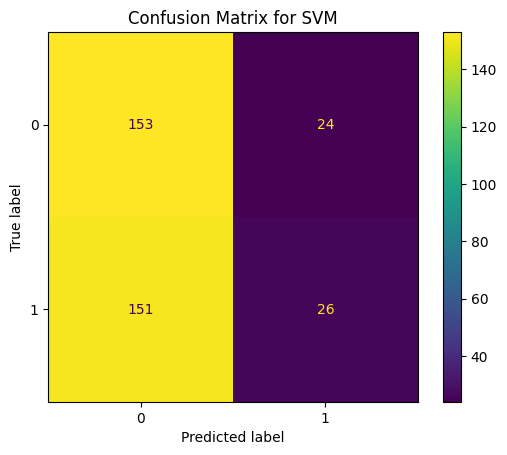

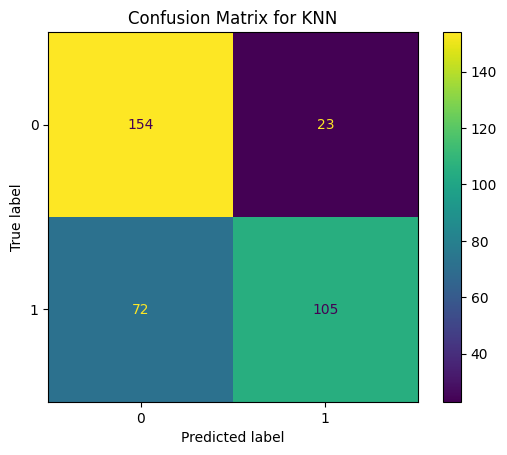

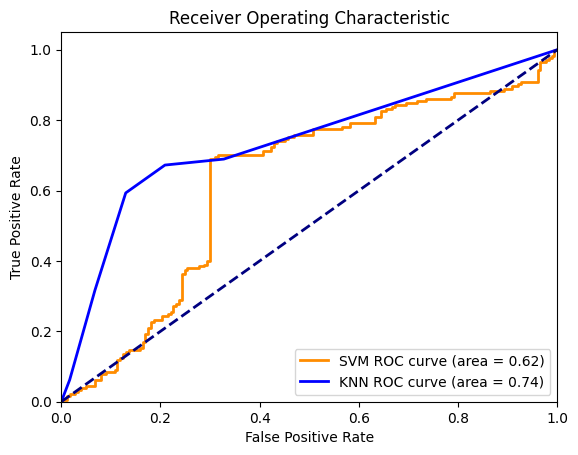

In [ ]:

# SVM Model
svm_model = SVC(kernel='rbf', gamma='auto', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_predictions = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_predictions)

# KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_predictions = knn_model.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, knn_predictions)

# Print model accuracy
print(f"SVM Accuracy: {svm_accuracy}")
print(f"KNN Accuracy: {knn_accuracy}")

# Calculate additional metrics
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)
svm_f1 = f1_score(y_test, svm_predictions)
knn_precision = precision_score(y_test, knn_predictions)
knn_recall = recall_score(y_test, knn_predictions)
knn_f1 = f1_score(y_test, knn_predictions)

# Display confusion matrix
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
knn_conf_matrix = confusion_matrix(y_test, knn_predictions)

ConfusionMatrixDisplay(svm_conf_matrix).plot()
plt.title('Confusion Matrix for SVM')
plt.show()

ConfusionMatrixDisplay(knn_conf_matrix).plot()
plt.title('Confusion Matrix for KNN')
plt.show()

# Calculate and plot ROC curves
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_model.decision_function(X_test_scaled))
roc_auc_svm = auc(fpr_svm, tpr_svm)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure()
lw = 2
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=lw, label='SVM ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot(fpr_knn, tpr_knn, color='blue', lw=lw, label='KNN ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

SVM Accuracy: 0.480225988700565
KNN Accuracy: 0.672316384180791


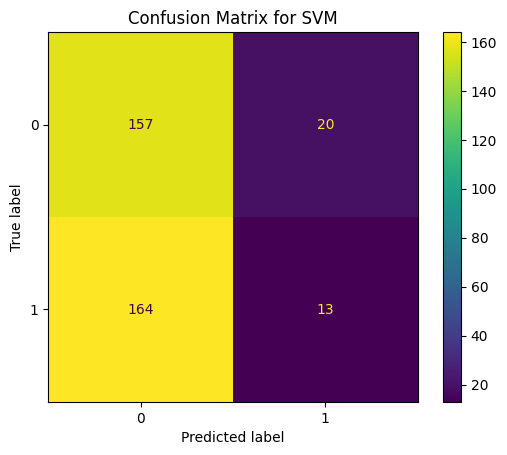

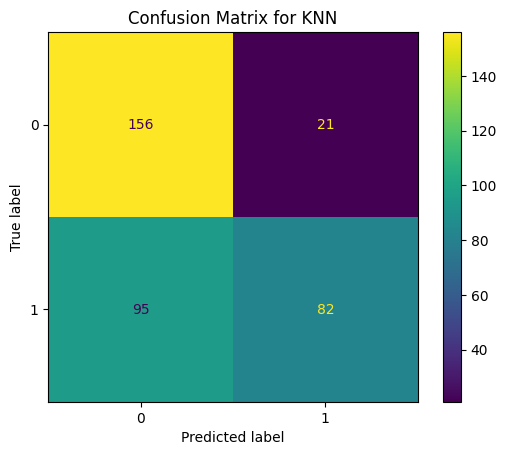

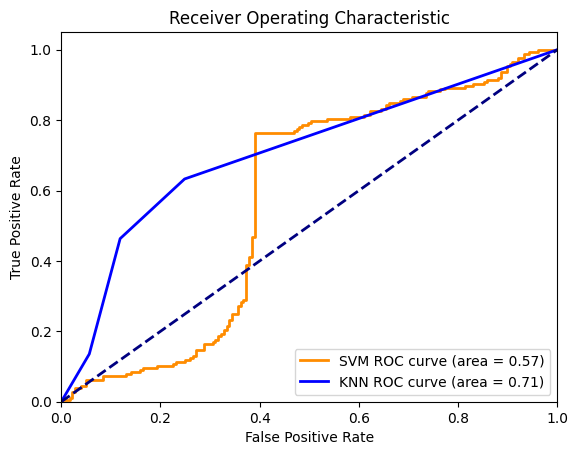

In [ ]:

# SVM Model
svm_model = SVC(**{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}, random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_predictions = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_predictions)

# KNN Model
knn_model = KNeighborsClassifier(**{'metric': 'euclidean', 'n_neighbors': 3})
knn_model.fit(X_train_scaled, y_train)
knn_predictions = knn_model.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, knn_predictions)

# Print model accuracy
print(f"SVM Accuracy: {svm_accuracy}")
print(f"KNN Accuracy: {knn_accuracy}")

# Calculate additional metrics
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)
svm_f1 = f1_score(y_test, svm_predictions)
knn_precision = precision_score(y_test, knn_predictions)
knn_recall = recall_score(y_test, knn_predictions)
knn_f1 = f1_score(y_test, knn_predictions)

# Display confusion matrix
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
knn_conf_matrix = confusion_matrix(y_test, knn_predictions)

ConfusionMatrixDisplay(svm_conf_matrix).plot()
plt.title('Confusion Matrix for SVM')
plt.show()

ConfusionMatrixDisplay(knn_conf_matrix).plot()
plt.title('Confusion Matrix for KNN')
plt.show()

# Calculate and plot ROC curves
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_model.decision_function(X_test_scaled))
roc_auc_svm = auc(fpr_svm, tpr_svm)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure()
lw = 2
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=lw, label='SVM ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot(fpr_knn, tpr_knn, color='blue', lw=lw, label='KNN ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Type of SVM kernel
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

# Create a GridSearchCV object
svm_grid_search = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy', verbose=1)
svm_grid_search.fit(X_train_scaled, y_train)

# Best SVM model
best_svm = svm_grid_search.best_estimator_
print("Best SVM Parameters:", svm_grid_search.best_params_)
print("Best SVM Accuracy:", svm_grid_search.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best SVM Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best SVM Accuracy: 0.7837179102986713


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],  # Number of neighbors
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# Create a GridSearchCV object
knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', verbose=1)
knn_grid_search.fit(X_train_scaled, y_train)

# Best KNN model
best_knn = knn_grid_search.best_estimator_
print("Best KNN Parameters:", knn_grid_search.best_params_)
print("Best KNN Accuracy:", knn_grid_search.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best KNN Parameters: {'metric': 'euclidean', 'n_neighbors': 3}
Best KNN Accuracy: 0.7327939266806511


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# For SVM
svm_precision = precision_score(y_test, best_svm.predict(X_test_scaled))
svm_recall = recall_score(y_test, best_svm.predict(X_test_scaled))
svm_f1 = f1_score(y_test, best_svm.predict(X_test_scaled))

# For KNN
knn_precision = precision_score(y_test, best_knn.predict(X_test_scaled))
knn_recall = recall_score(y_test, best_knn.predict(X_test_scaled))
knn_f1 = f1_score(y_test, best_knn.predict(X_test_scaled))


In [ ]:
#print(svm_precision,svm_recall,svm_f1)
print(f"svm_precistion: {svm_precision}, svm_recall: {svm_recall}, svm_f1: {svm_f1} ")

svm_precistion: 0.5517241379310345, svm_recall: 0.0903954802259887, svm_f1: 0.1553398058252427 


In [ ]:
# print(knn_precision,knn_recall,knn_f1)
print(f"knn_precession: {knn_precision}, knn_recall: {knn_recall}, knn_f1: {knn_f1}")

knn_precession: 0.7961165048543689, knn_recall: 0.4632768361581921, knn_f1: 0.5857142857142857


In [ ]:
# Calculate predictions on the training set
svm_train_predictions = best_svm.predict(X_train_scaled)
knn_train_predictions = best_knn.predict(X_train_scaled)

# Calculate accuracy on the training set
svm_train_accuracy = accuracy_score(y_train, svm_train_predictions)
knn_train_accuracy = accuracy_score(y_train, knn_train_predictions)

# Compare with the test accuracy
print(f"SVM Training Accuracy: {svm_train_accuracy}, Test Accuracy: {svm_accuracy}")
print(f"KNN Training Accuracy: {knn_train_accuracy}, Test Accuracy: {knn_accuracy}")


SVM Training Accuracy: 0.9830508474576272, Test Accuracy: 0.480225988700565
KNN Training Accuracy: 0.9830508474576272, Test Accuracy: 0.672316384180791


In [ ]:
from sklearn.model_selection import cross_val_score

np.random.seed(42)


svm_model = SVC(C=100, kernel='rbf', gamma='auto', random_state=42)
knn_model = KNeighborsClassifier(metric='euclidean', n_neighbors=3)

# Perform 5-fold cross-validation
svm_cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5)
knn_cv_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=5)


print(f"SVM 5-fold CV Accuracy: {np.mean(svm_cv_scores):.4f} (+/- {np.std(svm_cv_scores):.4f})")
print(f"KNN 5-fold CV Accuracy: {np.mean(knn_cv_scores):.4f} (+/- {np.std(knn_cv_scores):.4f})")


SVM 5-fold CV Accuracy: 0.7396 (+/- 0.2487)
KNN 5-fold CV Accuracy: 0.7328 (+/- 0.2309)
